In [610]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import random
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [2]:
def do_kfold_cv(dfX, dfy, model, num_splits):
    
    #kf = KFold(n_splits=num_splits, shuffle=True, random_state=0)

    scores = cross_val_score(model, dfX, dfy, scoring='accuracy',cv=num_splits)
    
    print('K-Fold number of splits:', num_splits)
    print(scores)
    print(np.mean(scores))
    
    return (np.mean(scores))

In [3]:
def make_submission_csv(model, Xtrain, y, Xtest, filename):
    
    model_f = model.fit(Xtrain, y)
    pred_ = pd.DataFrame(model_f.predict(Xtest), columns=['Cover_Type'], index=None)
    submit = pd.concat([test_df.Id, pred_], axis=1)
    submit.to_csv(filename, sep=',')

In [4]:
def drop_allzero_column(df):
    
    li = []
    for col in df.columns:
        
        if len(df[col].unique()) == 1:
           
            li.append(col)
            
    return df.drop(li, axis=1)

In [54]:
def draw_decomp(X, decomp, dim, y=None, fit=False):
    # test weight dictionary in LDA 2d
    if not fit:
        dec = decomp(n_components=dim)
        if not y:
            X_2d = dec.fit_transform(X)
        else:
            X_2d = dec.fit_transform(X, y)

    plt.scatter(X_2d[:,0], X_2d[:,1], c=y, s=10, cmap=plt.cm.RdYlGn)
    plt.colorbar()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('First two PCs using digits data')
    plt.show()

In [621]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    markers = ('s', 'x', 'o', '^', 'v', 'd', '*')
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'w')
    #cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1,X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    #plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=plt.cm.RdYlGn)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    #for idx, cl in enumerate(np.unique(y)):
    #    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
    #               alpha=0.8, c=cmap(idx),
    #               marker=markers[idx], label=cl)
     
    plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap=plt.cm.RdYlGn)
    plt.colorbar()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('First two PCs using digits data')
    plt.show()

In [53]:
def draw_confmat(confmat):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

In [7]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
y = train_df['Cover_Type']

In [8]:
X_scaled_test = pd.read_csv('data/X_scaled_test.csv')
X_scaled = pd.read_csv('data/X_scaled.csv')

In [9]:
X_scaled_ = drop_allzero_column(X_scaled)

In [10]:
#X_scaled = X_scaled.drop(['Unnamed: 0'], axis=1)
X_scaled_test = X_scaled_test.drop(['Unnamed: 0'], axis=1)

In [11]:
# kaggle test accuracy 0.799 feature set (train accuracy = 0.9)
X_scaled_bestset =\
        X_scaled[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                   'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                   'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points',
                   'Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4',
                   'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
                   'Soil_Type9', 'Soil_Type10', 'Soil_Type12', 'Soil_Type13',
                   'Soil_Type17', 'Soil_Type20', 'Soil_Type22', 'Soil_Type30',
                   'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39',
                   'Elevation_Cover3', 'Elevation_Cover4', 'Elevation_Cover5',
                   'Diagnoal_Distance_To_Hydrology', 'Vertical_Distance_Sum_EH',
                   'Vertical_Distance_Diff_EH', 'Vertical_Distance_Div_EH_SQRD',
                   'Horizontal_Distance_Sum_HRF', 'Horizontal_Distance_Sum_HR',
                   'Horizontal_Distance_Sum_HF', 'Horizontal_Distance_Sum_RF',
                   'Horizontal_Distance_Diff_HRF', 'Horizontal_Distance_Diff_HR_SQRD',
                   'Horizontal_Distance_Diff_HF_SQRD', 'Horizontal_Distance_Diff_RF_SQRD',
                   'Horizontal_Distance_Mult_HR', 'Horizontal_Distance_Mult_RF',
                   'Hillshade_Sum', 'Hillshade_ratio_0912', 'Hillshade_ratio_1215',
                   'Radians_To_Hydrology']]

In [647]:
etc_grid = ExtraTreesClassifier(max_depth=10, max_features=0.2, criterion='gini',\
                               n_estimators = 150, random_state=0)

In [649]:
etc_grid = ExtraTreesClassifier(max_depth=50, max_features=0.3, criterion='gini',
                               class_weight='balanced', n_estimators = 150, random_state=0)

In [650]:
do_kfold_cv(X_scaled_bestset, y, etc_grid, 10)

K-Fold number of splits: 10
[ 0.78835979  0.83267196  0.83134921  0.76587302  0.78637566  0.76124339
  0.80886243  0.84193122  0.8994709   0.87037037]
0.818650793651


0.81865079365079363

In [633]:
do_kfold_cv(X_scaled_bestset, y, ExtraTreesClassifier(random_state=0), 10)

K-Fold number of splits: 10
[ 0.74470899  0.80555556  0.79828042  0.74140212  0.77116402  0.72619048
  0.78505291  0.81216931  0.86706349  0.8531746 ]
0.790476190476


0.79047619047619044

In [494]:
confmat_summed = []
wrongs_indices = {}

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
                            X_scaled_bestset, y, test_size=0.1, random_state=i)
    
    etc_best_fit = etc_best.fit(X_train, y_train)
    y_hat = etc_best_fit.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_hat)
    
    compare = (y_test == y_hat)
    wrongs_idx = compare[compare==False].index
    
    for widx in wrongs_idx:
        widx_ = int(widx)
        
        if widx_ in wrongs_indices:
            wrongs_indices[widx_] += 1
        else:
            wrongs_indices[widx_] = 1
    
    if type(confmat_summed) != list:
        confmat_summed = np.add(confmat, confmat_summed)
    else:
        confmat_summed = confmat

In [535]:
print(len(wrongs_indices.keys()))
list(wrongs_indices.keys())

X_best_wrongs = X_scaled_bestset.iloc[list(wrongs_indices.keys())]

1056


In [536]:
etc_best

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=35, max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [554]:
notwrong_indices = [x for x in list(X_scaled_bestset.index) if x not in list(wrongs_indices.keys())]

In [555]:
len(notwrong_indices)

14064

In [556]:
X_best_notwrong = X_scaled_bestset.iloc[notwrong_indices]

In [558]:
shuffle(list(X_best_notwrong.index))[:7032]

[11180,
 8733,
 11667,
 2981,
 6068,
 12210,
 14327,
 2772,
 7047,
 8304,
 12192,
 12901,
 8550,
 10484,
 8982,
 4479,
 10896,
 7158,
 6779,
 11486,
 6015,
 5420,
 881,
 13941,
 2677,
 3809,
 9896,
 10299,
 5065,
 3523,
 1099,
 8006,
 140,
 6884,
 12887,
 720,
 9662,
 3133,
 5925,
 1010,
 6650,
 9899,
 4513,
 4732,
 5890,
 13622,
 12302,
 9618,
 12898,
 5957,
 12963,
 4796,
 3934,
 1404,
 7467,
 14813,
 14667,
 14638,
 11317,
 1746,
 11687,
 1471,
 14347,
 3507,
 11523,
 3635,
 6522,
 2662,
 790,
 6790,
 1445,
 3764,
 14773,
 6680,
 12042,
 13559,
 4976,
 12810,
 14513,
 9255,
 2133,
 10396,
 14745,
 5555,
 5013,
 12220,
 8752,
 12184,
 1243,
 12603,
 308,
 6226,
 12215,
 8411,
 11770,
 4825,
 5771,
 12164,
 4280,
 6165,
 10807,
 12627,
 551,
 8618,
 1537,
 5873,
 12774,
 12116,
 6317,
 12310,
 5564,
 12352,
 8257,
 5904,
 1025,
 8446,
 11285,
 9425,
 10903,
 10840,
 10488,
 5826,
 4311,
 7394,
 5128,
 13845,
 14125,
 7943,
 10266,
 10110,
 12435,
 14157,
 13940,
 1680,
 9454,
 10875,


In [573]:
y.iloc[list(wrongs_indices.keys())].value_counts()

2    349
1    296
3    174
6    128
5     48
4     36
7     25
Name: Cover_Type, dtype: int64

In [577]:
type(shuffle(list(X_best_notwrong.index))[:7032])

list

In [579]:
X_best_notwrong_half = X_best_notwrong.loc[shuffle(list(X_best_notwrong.index))[:7032]]

In [580]:
X_best_notwrong_half

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Horizontal_Distance_Diff_HRF,Horizontal_Distance_Diff_HR_SQRD,Horizontal_Distance_Diff_HF_SQRD,Horizontal_Distance_Diff_RF_SQRD,Horizontal_Distance_Mult_HR,Horizontal_Distance_Mult_RF,Hillshade_Sum,Hillshade_ratio_0912,Hillshade_ratio_1215,Radians_To_Hydrology
10621,0.887501,0.148283,-1.005671,0.032391,-0.148219,-1.199997,0.402343,1.097941,1.725477,-0.558711,...,-0.146179,-0.617243,1.407116,2.658849,-0.592614,-0.603808,1.055762,-0.001428,0.070972,-0.409621
4464,0.279357,1.456397,-0.650795,-0.353198,-1.062693,-0.034734,-0.742935,0.483939,-0.095597,-0.558711,...,0.037379,-0.254517,-0.244308,-0.439256,-0.270926,-0.200242,0.646990,0.028111,0.908080,-1.516822
9187,0.882712,-1.087158,-1.360547,-1.081532,-0.834074,0.188659,0.238732,0.440082,1.379991,-0.558711,...,-0.968792,-0.006346,1.231356,-0.131375,-0.633117,0.556427,0.549664,-0.011632,0.147687,2.091832
7366,1.478885,1.247462,-0.887379,0.322773,-0.360507,-0.183411,-0.546602,0.834797,-0.592006,-0.558711,...,0.467139,-0.399448,-0.487014,-0.351225,-0.017233,-0.427048,0.958435,0.028994,0.814176,-0.737681
9794,1.155659,0.984023,-1.005671,-0.653100,-0.768755,-0.809060,-0.415713,1.097941,-0.250157,-0.558711,...,0.587568,-0.570757,-0.294117,-0.357143,-0.551625,-0.526070,1.153089,0.030334,0.715555,-0.942718
2467,-0.072600,1.192958,-0.769087,-0.795911,-0.605456,-0.073224,-0.644768,0.878655,-0.459267,-0.558711,...,0.211225,-0.234018,-0.375305,-0.351225,-0.495523,-0.351109,0.997366,0.034630,0.885136,-0.204584
3589,0.949752,0.429891,1.833340,0.094276,-1.372961,0.211300,-0.906546,1.273371,1.895493,1.789833,...,-1.138753,-0.134284,1.627389,0.282429,0.066111,0.812891,0.841644,0.058572,0.546755,-1.680852
53,-0.573002,-0.705624,-0.295918,-0.167544,-0.523806,-0.621139,0.795009,-0.173921,3.467454,1.789833,...,-1.469449,-0.541540,4.563624,5.221432,-0.390662,0.303664,-0.170553,-0.042978,-0.609746,-0.737681
8634,0.882712,1.647164,-0.414210,0.275169,-1.062693,0.115452,-0.677491,0.133080,-0.608371,-0.558711,...,0.278724,-0.221551,-0.488755,-0.155529,0.122251,-0.362584,0.296614,0.015393,0.772619,-1.352793
5729,-0.831583,1.583575,0.650419,1.174876,2.284936,-0.560008,-1.626435,-0.524780,-0.427445,-0.558711,...,0.708484,-0.579765,-0.486574,-0.457714,0.020648,-0.480225,-0.326276,0.042016,1.364024,0.410527


In [582]:
X_best_halved = pd.concat([X_best_wrongs, X_best_notwrong_half], axis=0)
X_best_halved

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Horizontal_Distance_Diff_HRF,Horizontal_Distance_Diff_HR_SQRD,Horizontal_Distance_Diff_HF_SQRD,Horizontal_Distance_Diff_RF_SQRD,Horizontal_Distance_Mult_HR,Horizontal_Distance_Mult_RF,Hillshade_Sum,Hillshade_ratio_0912,Hillshade_ratio_1215,Radians_To_Hydrology
12289,1.189178,0.475312,-1.123963,-0.938722,-0.785085,0.535068,0.075120,1.229513,1.249070,1.789833,...,-1.107189,0.290612,1.032691,-0.397418,-0.529728,0.775071,1.230950,0.013662,0.370882,-0.696674
10243,0.952146,-0.651120,0.413835,1.550944,2.611534,-0.267183,1.024065,-0.744066,0.842670,-0.558711,...,-0.119956,-0.515700,0.140521,-0.123325,0.434409,0.003539,-0.812909,-0.061568,-1.143772,0.328512
6148,-1.049461,-1.168915,1.005295,-0.938722,-0.752425,-0.372087,-0.382991,-1.884356,-0.492906,-0.558711,...,0.406924,-0.393808,-0.377865,-0.440741,-0.581426,-0.444252,-1.766710,-0.050367,-0.244860,-0.450629
5,-0.407798,-0.224166,-1.242255,0.346574,-1.079023,-1.243015,0.565954,0.790940,4.109330,1.789833,...,-1.359703,-0.610541,5.824257,9.818046,-0.605266,-0.607560,0.783248,-0.014087,-0.097937,-1.352793
8198,1.325652,-0.215082,-0.059334,3.288474,2.219616,0.587142,1.024065,0.483939,0.736297,-0.558711,...,-0.435599,-0.225562,-0.167001,-0.450641,2.614737,0.521771,0.335545,-0.034670,-0.687375,-0.327607
14343,1.512404,0.139199,-0.059334,0.351335,0.292689,-0.056620,0.533231,1.185656,1.359990,1.789833,...,-0.654121,-0.334745,0.871910,0.081626,0.067148,0.342171,1.016831,-0.003821,-0.126092,-0.204584
8201,-0.017532,-0.932727,-0.532502,-0.653100,-0.638115,0.477710,0.467787,-0.261636,0.724477,-0.558711,...,-0.760953,0.190140,0.405642,-0.458650,-0.333083,0.444704,-0.190019,-0.035675,-0.314750,-0.573651
8202,-0.525117,-0.841886,-1.123963,0.375136,-0.393167,-0.659629,0.467787,0.308510,-0.193788,-0.558711,...,0.566202,-0.573862,-0.358006,-0.398482,-0.268607,-0.463744,0.374476,-0.022253,-0.109452,-0.778688
5463,0.389493,-0.324091,-0.769087,0.070474,-0.474817,0.316204,0.795009,0.571653,-0.632009,-0.558711,...,0.141298,-0.051055,-0.485025,0.042061,0.099764,-0.327192,0.530198,-0.026165,-0.370080,-0.778688
12,-0.017532,-0.205998,0.650419,-0.367479,0.292689,1.132793,1.154954,0.220795,4.163881,1.789833,...,-2.990360,0.873322,6.299880,1.930782,0.052014,3.418850,-0.053761,-0.043905,-1.041361,0.615565


In [583]:
y[X_best_halved.index]

12289    2
10243    1
6148     6
5        2
8198     1
14343    1
8201     3
8202     2
5463     2
12       2
4109     6
8877     1
8210     1
13315    3
4117     1
11609    1
137      1
8217     2
14362    2
4123     6
1814     5
10272    1
12323    3
10884    6
4134     4
40       1
41       2
2091     3
14380    1
3343     3
        ..
10793    3
11574    2
12295    3
14277    5
10844    3
338      1
12100    6
7921     7
8948     2
4882     4
10643    3
13437    6
14035    7
3488     5
8060     7
4463     1
3656     4
6101     4
1970     2
13543    5
3744     3
10646    3
12185    5
1906     6
5625     4
1803     2
8408     3
7740     7
9153     1
1131     1
Name: Cover_Type, dtype: int64

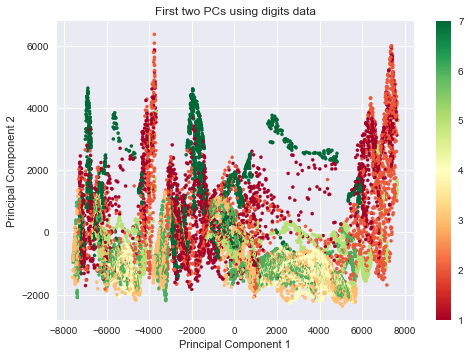

In [652]:
pca = PCA(n_components=2)
X_selected_2d = pca.fit_transform(train_df)

plt.scatter(X_selected_2d[:,0], X_selected_2d[:,1], c=y, s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


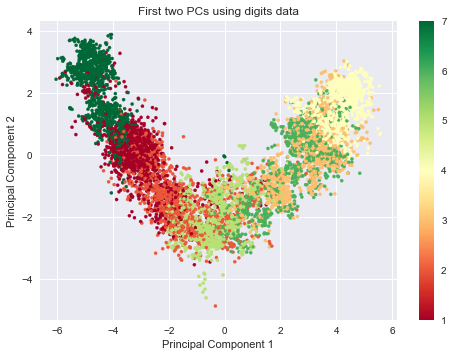

In [588]:
lda = LDA(n_components=2)
X_selected_2d_ = lda.fit_transform(X_best_halved, y[X_best_halved.index])

plt.scatter(X_selected_2d_[:,0], X_selected_2d_[:,1], c=y[X_best_halved.index], s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [590]:
do_kfold_cv(X_best_halved, y[X_best_halved.index], etc_best, 10)

K-Fold number of splits: 10
[ 0.42189422  0.64408867  0.78888889  0.90482077  0.91336634  0.91336634
  0.9244114   0.91945477  0.92069393  0.92069393]
0.827167924469


0.8271679244688851

In [606]:
make_submission_csv(etc_best, X_best_halved, y[X_best_halved.index], X_scaled_test[X_best_halved.columns],\
                   "best_halved_etc_best.csv")

In [608]:
do_kfold_cv(X_best_halved, y[X_best_halved.index], ada, 10)

K-Fold number of splits: 10
[ 0.42189422  0.64162562  0.79382716  0.92212608  0.91707921  0.92450495
  0.91945477  0.93060719  0.91697646  0.92565056]
0.83137462067


0.83137462066969847

In [593]:
X_best_notwrong_4000 = X_best_notwrong.loc[shuffle(list(X_best_notwrong.index))[:4000]]
X_best_5000 = pd.concat([X_best_wrongs, X_best_notwrong_4000], axis=0)
X_best_5000

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Horizontal_Distance_Diff_HRF,Horizontal_Distance_Diff_HR_SQRD,Horizontal_Distance_Diff_HF_SQRD,Horizontal_Distance_Diff_RF_SQRD,Horizontal_Distance_Mult_HR,Horizontal_Distance_Mult_RF,Hillshade_Sum,Hillshade_ratio_0912,Hillshade_ratio_1215,Radians_To_Hydrology
12289,1.189178,0.475312,-1.123963,-0.938722,-0.785085,0.535068,0.075120,1.229513,1.249070,1.789833,...,-1.107189,0.290612,1.032691,-0.397418,-0.529728,0.775071,1.230950,0.013662,0.370882,-0.696674
10243,0.952146,-0.651120,0.413835,1.550944,2.611534,-0.267183,1.024065,-0.744066,0.842670,-0.558711,...,-0.119956,-0.515700,0.140521,-0.123325,0.434409,0.003539,-0.812909,-0.061568,-1.143772,0.328512
6148,-1.049461,-1.168915,1.005295,-0.938722,-0.752425,-0.372087,-0.382991,-1.884356,-0.492906,-0.558711,...,0.406924,-0.393808,-0.377865,-0.440741,-0.581426,-0.444252,-1.766710,-0.050367,-0.244860,-0.450629
5,-0.407798,-0.224166,-1.242255,0.346574,-1.079023,-1.243015,0.565954,0.790940,4.109330,1.789833,...,-1.359703,-0.610541,5.824257,9.818046,-0.605266,-0.607560,0.783248,-0.014087,-0.097937,-1.352793
8198,1.325652,-0.215082,-0.059334,3.288474,2.219616,0.587142,1.024065,0.483939,0.736297,-0.558711,...,-0.435599,-0.225562,-0.167001,-0.450641,2.614737,0.521771,0.335545,-0.034670,-0.687375,-0.327607
14343,1.512404,0.139199,-0.059334,0.351335,0.292689,-0.056620,0.533231,1.185656,1.359990,1.789833,...,-0.654121,-0.334745,0.871910,0.081626,0.067148,0.342171,1.016831,-0.003821,-0.126092,-0.204584
8201,-0.017532,-0.932727,-0.532502,-0.653100,-0.638115,0.477710,0.467787,-0.261636,0.724477,-0.558711,...,-0.760953,0.190140,0.405642,-0.458650,-0.333083,0.444704,-0.190019,-0.035675,-0.314750,-0.573651
8202,-0.525117,-0.841886,-1.123963,0.375136,-0.393167,-0.659629,0.467787,0.308510,-0.193788,-0.558711,...,0.566202,-0.573862,-0.358006,-0.398482,-0.268607,-0.463744,0.374476,-0.022253,-0.109452,-0.778688
5463,0.389493,-0.324091,-0.769087,0.070474,-0.474817,0.316204,0.795009,0.571653,-0.632009,-0.558711,...,0.141298,-0.051055,-0.485025,0.042061,0.099764,-0.327192,0.530198,-0.026165,-0.370080,-0.778688
12,-0.017532,-0.205998,0.650419,-0.367479,0.292689,1.132793,1.154954,0.220795,4.163881,1.789833,...,-2.990360,0.873322,6.299880,1.930782,0.052014,3.418850,-0.053761,-0.043905,-1.041361,0.615565


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


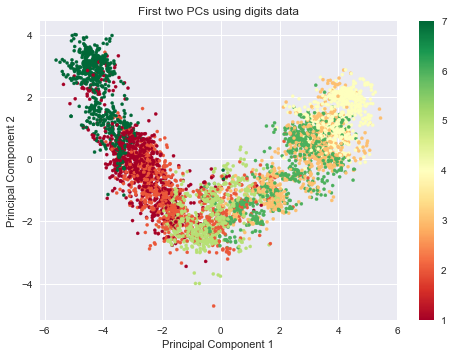

In [595]:
lda = LDA(n_components=2)
X_selected_2d_ = lda.fit_transform(X_best_5000, y[X_best_5000.index])

plt.scatter(X_selected_2d_[:,0], X_selected_2d_[:,1], c=y[X_best_5000.index], s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [596]:
do_kfold_cv(X_best_5000, y[X_best_5000.index], etc_best, 10)

K-Fold number of splits: 10
[ 0.32086614  0.50690335  0.63438735  0.6798419   0.8458498   0.86758893
  0.87326733  0.85544554  0.87326733  0.84661355]
0.730403122282


0.73040312228157411

In [609]:
do_kfold_cv(X_best_5000, y[X_best_5000.index], ada, 10)

K-Fold number of splits: 10
[ 0.32480315  0.50493097  0.64031621  0.68577075  0.8458498   0.87944664
  0.87524752  0.86138614  0.87326733  0.85458167]
0.734560017869


0.73456001786909952

In [612]:
do_kfold_cv(X_best_5000, y[X_best_5000.index], \
            XGBClassifier(random_state=0, objective='multi:softmax'), 10)

K-Fold number of splits: 10
[ 0.36417323  0.52465483  0.6027668   0.65217391  0.78458498  0.79644269
  0.76435644  0.77821782  0.78019802  0.7749004 ]
0.682246911577


0.68224691157743345

In [599]:
X_best_notwrong_10000 = X_best_notwrong.loc[shuffle(list(X_best_notwrong.index))[:10000]]
X_best_10000 = pd.concat([X_best_wrongs, X_best_notwrong_10000], axis=0)
X_best_10000

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Horizontal_Distance_Diff_HRF,Horizontal_Distance_Diff_HR_SQRD,Horizontal_Distance_Diff_HF_SQRD,Horizontal_Distance_Diff_RF_SQRD,Horizontal_Distance_Mult_HR,Horizontal_Distance_Mult_RF,Hillshade_Sum,Hillshade_ratio_0912,Hillshade_ratio_1215,Radians_To_Hydrology
12289,1.189178,0.475312,-1.123963,-0.938722,-0.785085,0.535068,0.075120,1.229513,1.249070,1.789833,...,-1.107189,0.290612,1.032691,-0.397418,-0.529728,0.775071,1.230950,0.013662,0.370882,-0.696674
10243,0.952146,-0.651120,0.413835,1.550944,2.611534,-0.267183,1.024065,-0.744066,0.842670,-0.558711,...,-0.119956,-0.515700,0.140521,-0.123325,0.434409,0.003539,-0.812909,-0.061568,-1.143772,0.328512
6148,-1.049461,-1.168915,1.005295,-0.938722,-0.752425,-0.372087,-0.382991,-1.884356,-0.492906,-0.558711,...,0.406924,-0.393808,-0.377865,-0.440741,-0.581426,-0.444252,-1.766710,-0.050367,-0.244860,-0.450629
5,-0.407798,-0.224166,-1.242255,0.346574,-1.079023,-1.243015,0.565954,0.790940,4.109330,1.789833,...,-1.359703,-0.610541,5.824257,9.818046,-0.605266,-0.607560,0.783248,-0.014087,-0.097937,-1.352793
8198,1.325652,-0.215082,-0.059334,3.288474,2.219616,0.587142,1.024065,0.483939,0.736297,-0.558711,...,-0.435599,-0.225562,-0.167001,-0.450641,2.614737,0.521771,0.335545,-0.034670,-0.687375,-0.327607
14343,1.512404,0.139199,-0.059334,0.351335,0.292689,-0.056620,0.533231,1.185656,1.359990,1.789833,...,-0.654121,-0.334745,0.871910,0.081626,0.067148,0.342171,1.016831,-0.003821,-0.126092,-0.204584
8201,-0.017532,-0.932727,-0.532502,-0.653100,-0.638115,0.477710,0.467787,-0.261636,0.724477,-0.558711,...,-0.760953,0.190140,0.405642,-0.458650,-0.333083,0.444704,-0.190019,-0.035675,-0.314750,-0.573651
8202,-0.525117,-0.841886,-1.123963,0.375136,-0.393167,-0.659629,0.467787,0.308510,-0.193788,-0.558711,...,0.566202,-0.573862,-0.358006,-0.398482,-0.268607,-0.463744,0.374476,-0.022253,-0.109452,-0.778688
5463,0.389493,-0.324091,-0.769087,0.070474,-0.474817,0.316204,0.795009,0.571653,-0.632009,-0.558711,...,0.141298,-0.051055,-0.485025,0.042061,0.099764,-0.327192,0.530198,-0.026165,-0.370080,-0.778688
12,-0.017532,-0.205998,0.650419,-0.367479,0.292689,1.132793,1.154954,0.220795,4.163881,1.789833,...,-2.990360,0.873322,6.299880,1.930782,0.052014,3.418850,-0.053761,-0.043905,-1.041361,0.615565


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


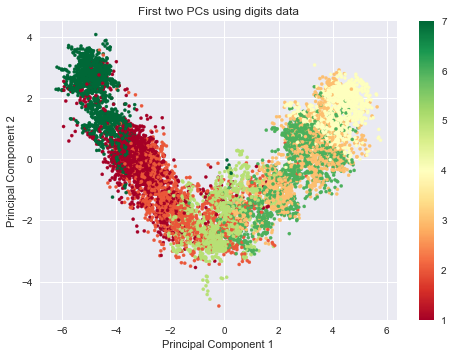

In [601]:
lda = LDA(n_components=2)
X_selected_2d_ = lda.fit_transform(X_best_10000, y[X_best_10000.index])

plt.scatter(X_selected_2d_[:,0], X_selected_2d_[:,1], c=y[X_best_10000.index], s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [603]:
do_kfold_cv(X_best_10000, y[X_best_10000.index], etc_best, 10)

K-Fold number of splits: 10
[ 0.47563177  0.72990063  0.91960253  0.92405063  0.92947559  0.93218807
  0.94117647  0.93031674  0.93653672  0.93200363]
0.865088277355


0.86508827735502813

In [607]:
do_kfold_cv(X_best_10000, y[X_best_10000.index], ada, 10)

K-Fold number of splits: 10
[ 0.47382671  0.73532069  0.92411924  0.92947559  0.93218807  0.93309222
  0.94660633  0.93122172  0.93653672  0.93653672]
0.867892400995


0.86789240099504639

In [613]:
do_kfold_cv(X_best_10000, y[X_best_10000.index], \
            XGBClassifier(random_state=0, objective='multi:softmax'), 10)

K-Fold number of splits: 10
[ 0.48285199  0.6802168   0.78139115  0.79927667  0.79566004  0.7920434
  0.80271493  0.80180995  0.82139619  0.80145059]
0.755881171185


0.75588117118543052

In [604]:
etc_best.fit(X_best_10000, y[X_best_10000.index])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=35, max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [605]:
make_submission_csv(etc_best, X_best_10000, y[X_best_10000.index], X_scaled_test[X_best_10000.columns],\
                   "X_best_10000_featureset_etc_best.csv")

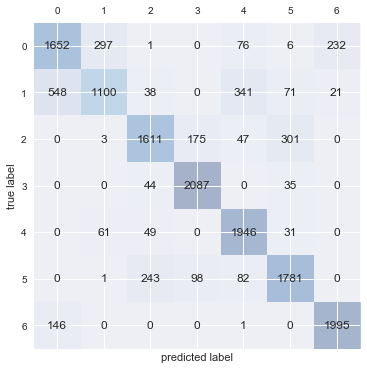

In [14]:
draw_confmat(confmat_summed)

In [505]:
confmat_avg = confmat_summed/50

tn = confmat_avg.sum(axis=1) - confmat_summed.diagonal()/50
tn_reg = tn / np.min(tn)

fp = confmat_avg.sum(axis=0) - confmat_summed.diagonal()/50
fp_reg = fp / np.min(fp)

In [506]:
test_weight_1 = {i+1 : np.log(tn)+1 for i, tn in enumerate(tn_reg)}
test_weight_2 = {i+1 : np.log(fp)+1 for i, fp in enumerate(fp_reg)}
test_weight_3 = {v1[0] : v1[1]*v2[1] for v1, v2  in zip(list(test_weight_1.items()), list(test_weight_2.items()))}

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


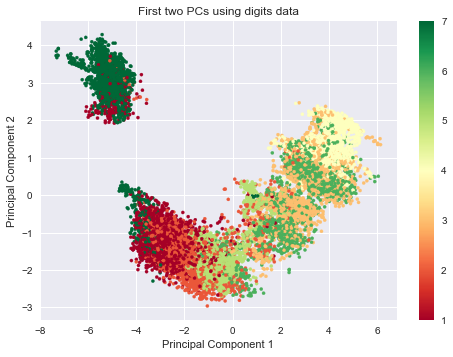

In [643]:
lda = LDA(n_components=2)
X_selected_2d_ = lda.fit_transform(train_df, y)

plt.scatter(X_selected_2d_[:,0], X_selected_2d_[:,1], c=y, s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [645]:
etc_grid.fit(X_selected_2d_, y)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=50, max_features=0.3,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

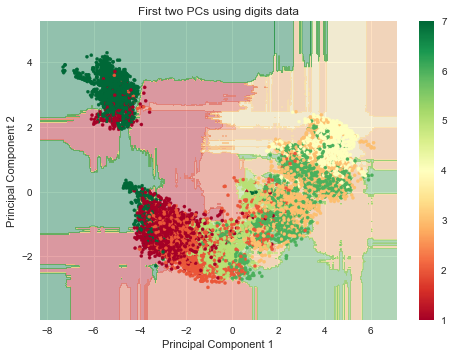

In [646]:
plot_decision_regions(X_selected_2d_, y, etc_grid)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


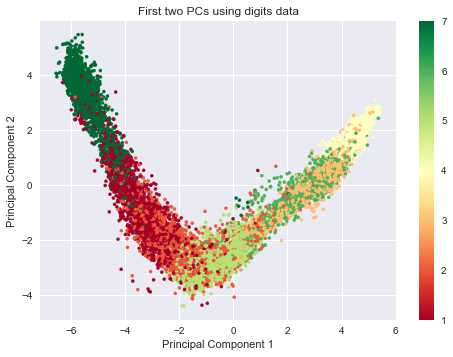

In [623]:
# test weight dictionary in LDA 2d

lda = LDA(n_components=2)
X_selected_2d_ = lda.fit_transform(X_scaled_, y)

plt.scatter(X_selected_2d_[:,0], X_selected_2d_[:,1], c=y, s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [627]:
etc_best.fit(X_selected_2d_, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=35, max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [632]:
do_kfold_cv(train_df.drop(['Cover_Type'],1), y, etc_best, 10)

K-Fold number of splits: 10
[ 0.50727513  0.70634921  0.71825397  0.64748677  0.74338624  0.6957672
  0.75        0.67592593  0.72883598  0.79034392]
0.696362433862


0.6963624338624339

In [641]:
etc_grid.fit(X_selected_2d_, y)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=50, max_features=0.3,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

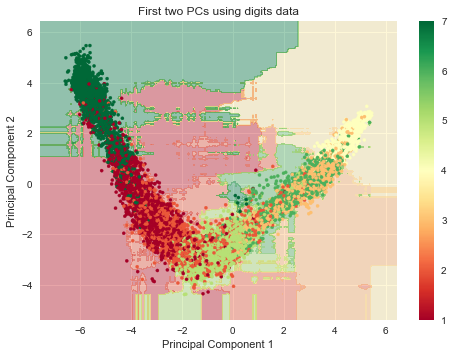

In [642]:
plot_decision_regions(X_selected_2d_, y, etc_grid)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


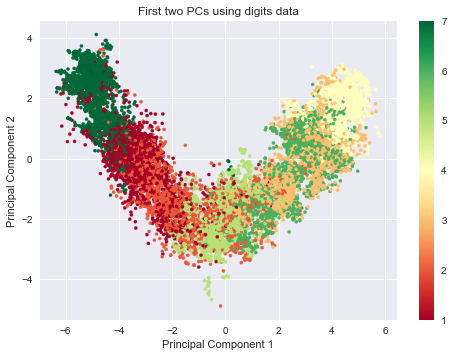

In [617]:
# test weight dictionary in LDA 2d

lda = LDA(n_components=2)
X_selected_2d = lda.fit_transform(X_scaled_bestset, y)

plt.scatter(X_selected_2d[:,0], X_selected_2d[:,1], c=y, s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [619]:
etc_best.fit(X_selected_2d, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=35, max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

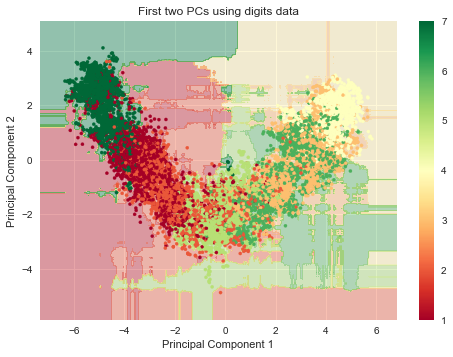

In [622]:
plot_decision_regions(X_selected_2d, y, etc_best)

0.604100529101


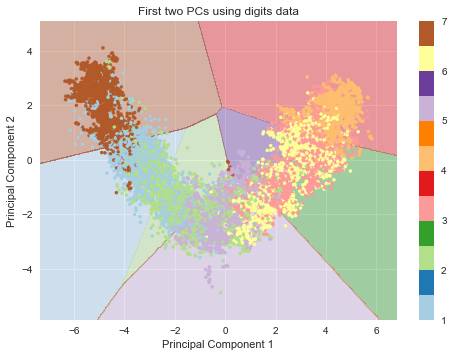

In [113]:
logreg = LogisticRegression().fit(X_selected_2d, y)
print(logreg.score(X_selected_2d, y))
plot_decision_regions(X_selected_2d, y, logreg)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.575330687831


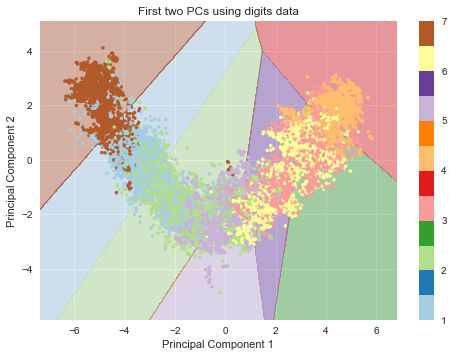

In [112]:
logreg2 = LogisticRegression(C=0.1, penalty='l1', solver='saga', multi_class='multinomial', class_weight=test_weight_3).fit(X_selected_2d, y)
print(logreg2.score(X_selected_2d, y))
plot_decision_regions(X_selected_2d, y, logreg2)

In [251]:
svm1 = SVC(C=0.01, kernel='rbf', gamma=1, class_weight=test_weight_3).fit(X_selected_2d, y)
print(svm1.score(X_selected_2d, y))
plot_decision_regions(X_selected_2d, y, svm1)

0.62294973545


KeyboardInterrupt: 

In [ ]:
svm1 = SVC(C=0.01, kernel='rbf', class_weight=test_weight_3).fit(X_selected_2d, y)
print(svm1.score(X_selected_2d, y))
plot_decision_regions(X_selected_2d, y, svm1)

In [124]:
logreg2 = LogisticRegression(C=0.1, penalty='l1', solver='saga', multi_class='multinomial', class_weight=test_weight_3).fit(X_scaled_bestset, y)
print(logreg2.score(X_scaled_bestset, y))

0.696759259259


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [125]:
logreg2 = LogisticRegression(C=0.1, penalty='l1', solver='saga', multi_class='multinomial', class_weight=test_weight_2).fit(X_scaled_bestset, y)
print(logreg2.score(X_scaled_bestset, y))

0.706084656085


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [126]:
logreg2 = LogisticRegression(C=0.1, penalty='l1', solver='saga', multi_class='multinomial', class_weight=test_weight_1).fit(X_scaled_bestset, y)
print(logreg2.score(X_scaled_bestset, y))

0.704761904762


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [89]:
lda_dim6 = LDA(n_components=6)
X_dim6 = lda_dim6.fit_transform(X_scaled_bestset, y)

logreg2 = LogisticRegression(C=0.1, penalty='l1', solver='saga', multi_class='multinomial', class_weight=test_weight_3).fit(X_dim6, y)
print(logreg2.score(X_dim6, y))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.647156084656


In [106]:
pca_dim6 = TruncatedSVD(n_components=20)
X_dim6_pca = pca_dim6.fit_transform(X_scaled_bestset)

logreg2_pca = LogisticRegression(C=0.1, penalty='l1', solver='saga', multi_class='multinomial', class_weight=test_weight_3).fit(X_dim6_pca, y)
print(logreg2_pca.score(X_dim6_pca, y))

0.648214285714


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


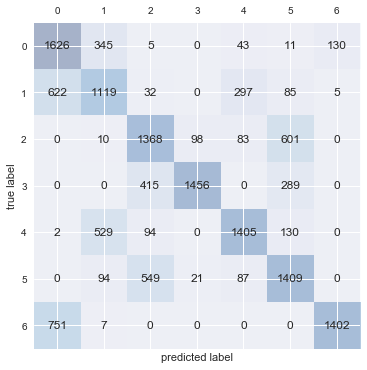

In [90]:
logreg2_pred = logreg2.predict(X_dim6)
confmat = confusion_matrix(y_true=y, y_pred=logreg2_pred)

draw_confmat(confmat)

In [120]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(
                            X_scaled_bestset, y, test_size=0.3, random_state=0)

# Confusion Matrix by Weights Set

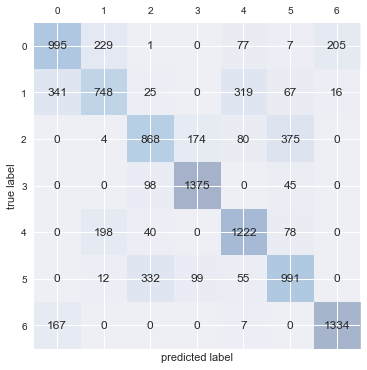

0.711734693878


In [163]:
logreg_train1 = LogisticRegression(C=0.1, penalty='l1', solver='saga',\
                                          multi_class='multinomial', \
                                          class_weight="balanced", tol=0.01)\
                                        .fit(X_train1, y_train1)

train1_pred = pd.Series(logreg_train1.predict(X_train1), index=y_train1.index)
draw_confmat(confusion_matrix(y_train1, train1_pred))

print(logreg_train1.score(X_train1, y_train1))

In [152]:
X_train1.shape[0]/7

1512.0

In [189]:
wrong_index = (y_train1 == train1_pred)[(y_train1 == train1_pred) == False].index

In [174]:
y_train1[wrong_index].value_counts()

2    768
3    633
1    519
6    498
5    316
7    174
4    143
Name: Cover_Type, dtype: int64

In [176]:
tn = confmat.sum(axis=1) - confmat.diagonal()
tn_reg = tn / np.min(tn)

fp = confmat.sum(axis=0) - confmat.diagonal()
fp_reg = fp / np.min(fp)

test_weight_1_t1 = {i+1 : np.log(tn)+1 for i, tn in enumerate(tn_reg)}
test_weight_2_t1 = {i+1 : np.log(fp)+1 for i, fp in enumerate(fp_reg)}
test_weight_3_t1 = {v1[0] : v1[1]*v2[1] for v1, v2  in zip(list(test_weight_1.items()), list(test_weight_2.items()))}

In [194]:
X_train1_wrong1, X_train1_wrong2, y_train1_wrong1, y_train1_wrong2 = train_test_split(
                            X_train1.loc[wrong_index], y_train1[wrong_index], \
                            test_size=0.5, random_state=0)

### X_train2 + X_train1_wrong1
두번째 모델의 학습에 사용한다.
* 4536 samples (X_train2)
* 1525 samples (X_train1_wrong1)

In [197]:
# 
X_train2_comb = pd.concat([X_train2, X_train1_wrong1], axis=0)
y_train2_comb = pd.concat([y_train2, y_train1_wrong1], axis=0)

In [207]:
test_nb = GaussianNB()
test_dtc = DecisionTreeClassifier()
test_knn = KNeighborsClassifier(n_neighbors=7)

In [206]:
test_fit_nb = test_nb.fit(X_train2_comb, y_train2_comb)
test_fit_nb.score(X_train2_comb, y_train2_comb)

0.42121762085464443

In [201]:
test_fit_dtc = test_dtc.fit(X_train2_comb, y_train2_comb)
test_fit_dtc.score(X_train2_comb, y_train2_comb)

1.0

In [208]:
test_fit_knn = test_knn.fit(X_train2_comb, y_train2_comb)
test_fit_knn.score(X_train2_comb, y_train2_comb)

0.77891437056591317

In [221]:
# KNeighbors
# 그리드 검색을 통한 하이퍼파라미터 튜닝

#kn_gridsearch_by_dim = {}

pipe_svc = Pipeline([('clf', KNeighborsClassifier(n_neighbors=7))])

param_grid = [{'clf__algorithm': ['auto'],
              'clf__weights':['uniform', 'distance'],
              'clf__p' : [1, 2]}]

gs_test_kn1 = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_test_kn1 = gs_test_kn1.fit(X_train2_comb, y_train2_comb)

print(gs_test_kn1.best_score_)
print(gs_test_kn1.best_params_)
print('#####')

0.749051311665
{'clf__algorithm': 'auto', 'clf__weights': 'distance', 'clf__p': 1}
#####


In [244]:
test_knn = KNeighborsClassifier(n_neighbors=7, algorithm='auto', weights='distance', p=1)
test_fit_knn = test_knn.fit(X_train2_comb, y_train2_comb)
test_fit_knn.score(X_train2_comb, y_train2_comb)

1.0

In [395]:
do_kfold_cv(X_scaled_bestset, y, test_fit_knn, 5)

K-Fold number of splits: 5
[ 0.75496032  0.70667989  0.71230159  0.7771164   0.82242063]
0.754695767196


0.75469576719576714

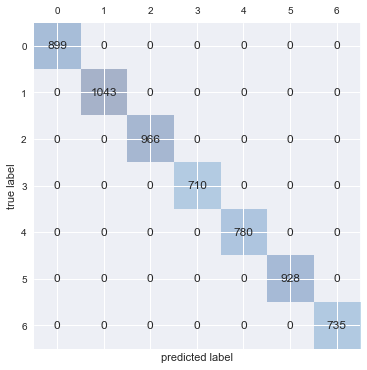

In [245]:
knn_pred = test_fit_knn.predict(X_train2_comb)
confmat = confusion_matrix(y_true=y_train2_comb, y_pred=knn_pred)
draw_confmat(confmat)

In [ ]:
lda = LDA(n_components=2)
X_train2_2d = lda.fit_transform(X_train2_comb, y_train2_comb)

In [393]:
test_knn2 = KNeighborsClassifier(n_neighbors=7, algorithm='auto', weights='distance', p=1)
test_fit_knn2 = test_knn2.fit(X_train2_2d, y_train2_comb)
test_fit_knn2.score(X_train2_2d, y_train2_comb)

1.0

In [394]:
do_kfold_cv(X_scaled_bestset, y, test_fit_knn2, 5)

K-Fold number of splits: 5
[ 0.75496032  0.70667989  0.71230159  0.7771164   0.82242063]
0.754695767196


0.75469576719576714

# KNN
2차원 변형하여 대략적인 분류 형태를 유추

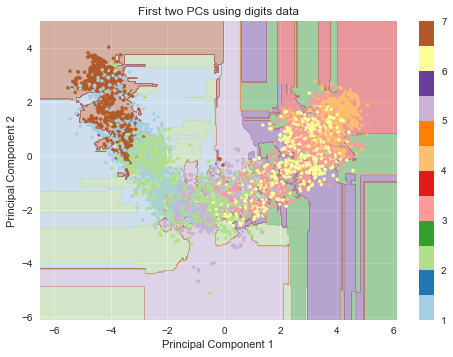

In [243]:
plot_decision_regions(X_train2_2d, y_train2_comb, test_fit_knn2)

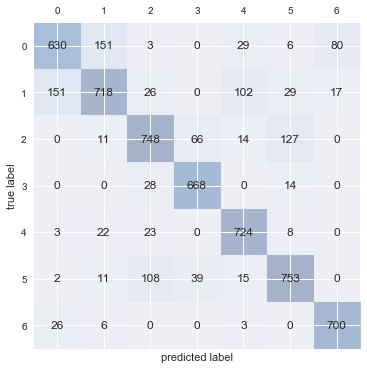

In [248]:
test_fit_knn2 = test_knn2.fit(X_train2_comb, y_train2_comb)

knn_pred = test_fit_knn2.predict(X_train2_comb)
confmat = confusion_matrix(y_true=y_train2_comb, y_pred=knn_pred)
draw_confmat(confmat)

In [250]:
tn = confmat.sum(axis=1) - confmat.diagonal()
tn_reg = tn / np.min(tn)

fp = confmat.sum(axis=0) - confmat.diagonal()
fp_reg = fp / np.min(fp)

test_weight_1_t2 = {i+1 : np.log(tn)+1 for i, tn in enumerate(tn_reg)}
test_weight_2_t2 = {i+1 : np.log(fp)+1 for i, fp in enumerate(fp_reg)}
test_weight_3_t2 = {v1[0] : v1[1]*v2[1] for v1, v2  in zip(list(test_weight_1.items()), list(test_weight_2.items()))}

In [253]:
print(test_weight_1_t1)
print(test_weight_2_t1)
print(test_weight_3_t1)

{1: 1.0, 2: 1.667541229654774, 3: 1.3941655528542309, 4: 1.2763825171978476, 5: 1.3463219102888297, 6: 1.3410098128039398, 7: 1.3502875466821767}
{1: 3.4470855169891421, 2: 3.1135181480605594, 3: 3.2193861491390718, 4: 1.0, 5: 2.455287232606842, 6: 3.238382649829727, 7: 1.1261512853269}
{1: 3.4470855169891421, 2: 5.1919198811693601, 3: 4.4883572704657277, 4: 1.2763825171978476, 5: 3.3056069973110178, 6: 4.3427029110356887, 7: 1.5206280562570398}


In [252]:
print(test_weight_1_t2)
print(test_weight_2_t2)
print(test_weight_3_t2)

{1: 3.0393633181124255, 2: 3.2284771208403238, 3: 2.8291470012996753, 4: 1.1823215567939547, 5: 1.4700036292457357, 6: 2.6094379124341005, 7: 1.0}
{1: 1.6292957085734125, 2: 1.7285939295556929, 3: 1.6617309843265664, 4: 1.0792493716541405, 5: 1.5190392223033795, 6: 1.6402247791056026, 7: 1.0}
{1: 3.4470855169891421, 2: 5.1919198811693601, 3: 4.4883572704657277, 4: 1.2763825171978476, 5: 3.3056069973110178, 6: 4.3427029110356887, 7: 1.5206280562570398}


# DecisionTreeClassifier Trainset
* X_train1_wrong2 (1525)
* X_train2_comb_wrong (1120)
* randomly pulled from X_train1 (not wrong, 2000)
* randomly pulled from X_train2 (not wrong, 1000)

In [268]:
knn_pred = pd.Series(knn_pred, index=y_train2_comb.index)

In [269]:
wrong_index2 = (y_train2_comb == knn_pred)[(y_train2_comb == knn_pred) == False].index

In [270]:
wrong_index2

Int64Index([ 2946,  5118, 13442,   643,  9793, 12194,  8198,  1667,  6629,
            13841,
            ...
            13771,  6812, 10415,  4771,  7262,  8942,   786,  3711,  7303,
             4745],
           dtype='int64', length=1120)

In [271]:
wrong_index

Int64Index([11573,  5078,  1551,  4324,  2179,  1906,  5712, 13208, 14847,
            12514,
            ...
             2496,  7599,  2046,  5072,  2163,  6216,  6744, 14116,  5874,
             3264],
           dtype='int64', length=3051)

In [283]:
X_train1_notwrong = X_train1.drop(wrong_index, axis=0) #7533
y_train1_notwrong = y_train1.drop(wrong_index, axis=0)

In [285]:
X_train2_comb_notwrong = X_train2_comb.drop(wrong_index2, axis=0) # 4941
y_train2_comb_notwrong = y_train2_comb.drop(wrong_index2, axis=0)

In [288]:
X_train3 = pd.concat([X_train1_notwrong[5533:],\
           X_train2_comb_notwrong[3941:],\
           X_train1_wrong2,\
           X_train2_comb.loc[wrong_index2]], axis=0)

In [289]:
y_train3 = pd.concat([y_train1_notwrong[5533:],\
                      y_train2_comb_notwrong[3941:],\
                      y_train1_wrong2,\
                      y_train2_comb.loc[wrong_index2]])

In [335]:
X_train3_a = pd.concat([X_train1_wrong2,\
           X_train2_comb.loc[wrong_index2]], axis=0)

y_train3_a = pd.concat([y_train1_wrong2,\
                      y_train2_comb.loc[wrong_index2]], axis=0)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


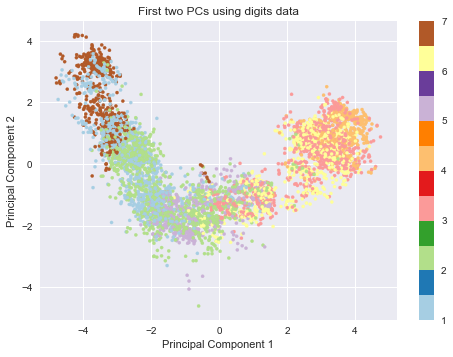

In [350]:
lda = LDA(n_components=2)
X_selected_2d = lda.fit_transform(X_train3, y_train3)

plt.scatter(X_selected_2d[:,0], X_selected_2d[:,1], c=y_train3, s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


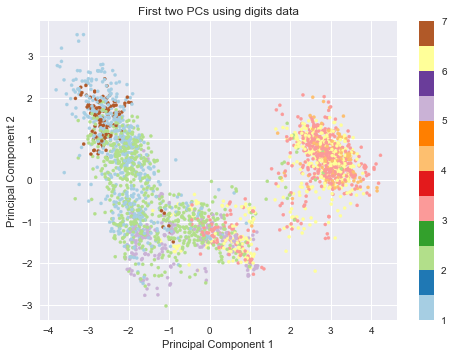

In [349]:
lda = LDA(n_components=2)
X_selected_2d = lda.fit_transform(X_train3_a, y_train3_a)

plt.scatter(X_selected_2d[:,0], X_selected_2d[:,1], c=y_train3_a, s=10, cmap=plt.cm.RdYlGn)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First two PCs using digits data')
plt.show()

In [302]:
test_weight_1_t2

{1: 3.0393633181124255,
 2: 3.2284771208403238,
 3: 2.8291470012996753,
 4: 1.1823215567939547,
 5: 1.4700036292457357,
 6: 2.6094379124341005,
 7: 1.0}

In [354]:
lda = LDA()
dtc = DecisionTreeClassifier(random_state=0)

pipe_svc = Pipeline([('dim',lda)
                     ,('clf', DecisionTreeClassifier(random_state=0))])

param_grid = [{'dim__n_components':range(2, 45),
               'clf__max_features': [0.3, 0.5, 'sqrt'],
              'clf__max_depth' : [25, 30, 35],
              'clf__class_weight':['balanced',
                                  test_weight_1_t1,
                                  test_weight_2_t1,
                                  test_weight_3_t1,
                                  test_weight_1_t2,
                                  test_weight_2_t2,
                                  test_weight_3_t2],
              'clf__splitter':['best', 'random']}]

#X_selected_2d = lda.fit_transform(X_train3_a, y_train3_a)

gs_test = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_test2 = gs_test.fit(X_train3, y_train3)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [355]:
print(gs_test2.best_score_)
print(gs_test2.best_params_)
print('#####')

0.551540913921
{'clf__max_depth': 30, 'clf__class_weight': 'balanced', 'clf__max_features': 'sqrt', 'dim__n_components': 6, 'clf__splitter': 'best'}
#####


In [353]:
lda = LDA()
dtc = DecisionTreeClassifier(random_state=0)

pipe_svc = Pipeline([('dim',lda)
                     ,('clf', DecisionTreeClassifier(random_state=0))])

param_grid = [{'dim__n_components':range(2, 45),
               'clf__max_features': [0.3, 0.5, 'sqrt'],
              'clf__max_depth' : [25, 30, 35],
              'clf__class_weight':['balanced',
                                  test_weight_1_t1,
                                  test_weight_2_t1,
                                  test_weight_3_t1,
                                  test_weight_1_t2,
                                  test_weight_2_t2,
                                  test_weight_3_t2],
              'clf__splitter':['best', 'random']}]

#X_selected_2d = lda.fit_transform(X_train3_a, y_train3_a)

gs_test = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_test = gs_test.fit(X_train3_a, y_train3_a)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [356]:
print(gs_test.best_score_)
print(gs_test.best_params_)
print('#####')

0.551540913921
{'clf__max_depth': 30, 'clf__class_weight': 'balanced', 'clf__max_features': 'sqrt', 'dim__n_components': 6, 'clf__splitter': 'best'}
#####


In [340]:
svm1 = SVC(C=0.01, kernel='rbf', class_weight=test_weight_3).fit(X_train3_a, y_train3_a)
print(svm1.score(X_train3_a, y_train3_a))
#plot_decision_regions(X_train3_a, y_train3_a, svm1)

0.414588057445


In [363]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train3_a, y_train3_a)
rf.score(X_train3_a, y_train3_a)

0.99168556311413458

In [364]:
do_kfold_cv(X_train3_a, y_train3_a, rf, 10)

K-Fold number of splits: 10
[ 0.67164179  0.67537313  0.71268657  0.74626866  0.71698113  0.68560606
  0.51145038  0.48659004  0.55555556  0.60153257]
0.636368588453


0.63636858845341926

In [387]:
rf_pred = pd.Series(rf.predict(X_train3_a), index=y_train3_a.index)

In [389]:
rf_wrongs_idx = (y_train3_a == rf_pred)[(y_train3_a == rf_pred) == False].index
y_train3_a[rf_wrongs_idx].value_counts()

2    7
1    7
7    3
6    2
5    2
3    1
Name: Cover_Type, dtype: int64

# Custom Emsemble Test
* etc
* knn
* rf

In [397]:
etc_grid = ExtraTreesClassifier(max_depth=10, max_features=0.2, criterion='gini',\
                               n_estimators = 150) 
etc = etc_grid.fit(X_scaled_bestset, y)

In [400]:
knn = test_fit_knn2
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=1,
           weights='distance')

In [440]:
etc_proba = etc.predict_proba(X_scaled_test[X_scaled_bestset.columns])

In [408]:
test_knn = KNeighborsClassifier(n_neighbors=7, algorithm='auto', weights='distance', p=1)
test_fit_knn = test_knn.fit(X_train2_comb, y_train2_comb)
knn_proba = test_fit_knn.predict_proba(X_scaled_test[X_scaled_bestset.columns])

In [409]:
knn_proba

array([[ 0.43757693,  0.40648204,  0.        , ...,  0.15594103,
         0.        ,  0.        ],
       [ 0.56504018,  0.31860261,  0.        , ...,  0.1163572 ,
         0.        ,  0.        ],
       [ 0.61223043,  0.25513323,  0.        , ...,  0.13263634,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.651112  , ...,  0.        ,
         0.348888  ,  0.        ],
       [ 0.        ,  0.        ,  0.59792468, ...,  0.        ,
         0.40207532,  0.        ],
       [ 0.        ,  0.        ,  0.72133008, ...,  0.        ,
         0.27866992,  0.        ]])

In [416]:
knn_proba.shape

(565892, 7)

In [411]:
rf_proba = rf.predict_proba(X_scaled_test[X_scaled_bestset.columns])

In [412]:
rf_proba.shape

(565892, 7)

In [422]:
rf_proba[1].max()

0.5

In [427]:
rf_proba_df = pd.DataFrame(rf_proba, columns=range(1,8))

In [433]:
rf_proba_df.iloc[0]

1    0.1
2    0.4
3    0.0
4    0.0
5    0.5
6    0.0
7    0.0
Name: 0, dtype: float64

In [468]:
r_ = rf_proba_df.iloc[0]
type(int(list(r_[r_ == r_.max()].index)[0]))

int

In [449]:
def instant_ensemble(proba_list, vote='hard'):
    
    proba_sum = ''
    test_pred = []
    
    for i, prob in enumerate(proba_list):
        if i != 0:
            proba_sum = np.add(proba_sum, prob)
        else:
            proba_sum = prob
    
    #print(proba_sum)
    
    proba_sum = pd.DataFrame(proba_sum, columns=range(1,8))
    proba_mean = proba_sum / len(proba_list)
        
    for row in range(proba_sum.shape[0]):
        
        row_ = proba_mean.iloc[row]
        
        row_max = row_.max()
        pred_cover = row_[row_ == row_max].index
        
        test_pred.append(int(list(pred_cover)[0]))
        
    return test_pred

In [450]:
inst_ensemble_pred = instant_ensemble([etc_proba, knn_proba, rf_proba], vote='hard')

In [477]:
inst_ensemble_pred = pd.Series(inst_ensemble_pred).apply(lambda x: int(list(x)[12]))

In [480]:
submit_df = pd.concat([test_df.Id, inst_ensemble_pred], axis=1)
submit_df.to_csv("custom_ensemble_etc-knn-rf.csv") # 0.719

In [366]:
# RandomForest
# 그리드 검색을 통한 하이퍼파라미터 튜닝

pipe_svc = Pipeline([('clf', RandomForestClassifier(random_state=0))])

param_grid = [{'clf__n_estimators': [150],
              'clf__criterion':['gini', 'entropy'],
              'clf__max_depth' : [20, 35, 50],
              'clf__class_weight':['balanced',
                                   'balanced_subsample',
                                  test_weight_1_t1,
                                  test_weight_2_t1,
                                  test_weight_3_t1,
                                  test_weight_1_t2,
                                  test_weight_2_t2,
                                  test_weight_3_t2]}]

gs_rf = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_rf_fit = gs_rf.fit(X_train3_a, y_train3_a)

KeyboardInterrupt: 

In [ ]:
print(gs_rf_fit.best_score_)
print(gs_rf_fit.best_params_)
print('#####')

# AdaBoost GridSearch

In [377]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=600,
                        learning_rate=0.13, random_state=0)

ada = ada.fit(X_train3_a, y_train3_a)
ada.score(X_train3_a, y_train3_a)

0.78382464096749815

In [383]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=10)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500,
                        learning_rate=0.13, random_state=0)

ada = ada.fit(X_train3_a, y_train3_a)
ada.score(X_train3_a, y_train3_a)

1.0

In [384]:
do_kfold_cv(X_train3_a, y_train3_a, ada, 5)

K-Fold number of splits: 5
[ 0.63721805  0.68113208  0.69376181  0.48204159  0.55513308]
0.609857320616


0.60985732061577835

In [482]:
# AdaBoost
# 그리드 검색을 통한 하이퍼파라미터 튜닝

for i in range(5, 15):
    
    tree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    
    pipe_svc = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree,
                                                    random_state=0))])

    param_grid = [{'clf__n_estimators': [500],
                  'clf__learning_rate' : [0.1, 0.15, 0.2],
                  }]

    gs_ada = GridSearchCV(estimator=pipe_svc,
                     param_grid = param_grid,
                      scoring='accuracy',
                     cv=10, n_jobs=-1)

    gs_ada_fit = gs_ada.fit(X_scaled_bestset, y)
    
    print(gs_ada_fit.best_score_)
    print(gs_ada_fit.best_params_)
    print('#####')

0.581349206349
{'clf__learning_rate': 0.2, 'clf__n_estimators': 500}
#####
0.645304232804
{'clf__learning_rate': 0.15, 'clf__n_estimators': 500}
#####
0.709920634921
{'clf__learning_rate': 0.2, 'clf__n_estimators': 500}
#####
0.755555555556
{'clf__learning_rate': 0.2, 'clf__n_estimators': 500}
#####
0.76917989418
{'clf__learning_rate': 0.2, 'clf__n_estimators': 500}
#####
0.787698412698
{'clf__learning_rate': 0.1, 'clf__n_estimators': 500}
#####
0.798743386243
{'clf__learning_rate': 0.2, 'clf__n_estimators': 500}
#####
0.798478835979
{'clf__learning_rate': 0.1, 'clf__n_estimators': 500}
#####
0.8
{'clf__learning_rate': 0.1, 'clf__n_estimators': 500}
#####
0.801984126984
{'clf__learning_rate': 0.15, 'clf__n_estimators': 500}
#####


In [485]:
ada_tree = DecisionTreeClassifier(max_depth=15, criterion='gini')
ada = AdaBoostClassifier(base_estimator=ada_tree, random_state=0, n_estimators=500,\
                  learning_rate=0.15) 

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.72883598  0.81481481  0.81216931  0.74404762  0.7744709   0.76851852
  0.77645503  0.82208995  0.86970899  0.85449735]
0.796560846561


0.79656084656084647

In [486]:
ada_tree = DecisionTreeClassifier(max_depth=20, criterion='gini')
ada = AdaBoostClassifier(base_estimator=ada_tree, random_state=0, n_estimators=500,\
                  learning_rate=0.15) 

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.75        0.8260582   0.81547619  0.75661376  0.77843915  0.69312169
  0.77910053  0.82208995  0.89021164  0.85582011]
0.796693121693


0.79669312169312168

In [487]:
# AdaBoost
# 그리드 검색을 통한 하이퍼파라미터 튜닝

for i in range(16, 21):
    
    tree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    
    pipe_svc = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree,
                                                    random_state=0))])

    param_grid = [{'clf__n_estimators': [500, 700],
                  'clf__learning_rate' : [0.1, 0.2],
                  }]

    gs_ada = GridSearchCV(estimator=pipe_svc,
                     param_grid = param_grid,
                      scoring='accuracy',
                     cv=10, n_jobs=-1)

    gs_ada_fit = gs_ada.fit(X_scaled_bestset, y)
    
    print(gs_ada_fit.best_score_)
    print(gs_ada_fit.best_params_)
    print('#####')

0.802447089947
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}
#####
0.801653439153
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}
#####


KeyboardInterrupt: 


16 depth//0.802447089947
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}

##### .
17 depth//0.801653439153
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}

In [488]:
# AdaBoost
# 그리드 검색을 통한 하이퍼파라미터 튜닝

for i in range(18, 25):
    
    tree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    
    pipe_svc = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree,
                                                    random_state=0))])

    param_grid = [{'clf__n_estimators': [700, 1000],
                  'clf__learning_rate' : [0.1, 0.2],
                  }]

    gs_ada = GridSearchCV(estimator=pipe_svc,
                     param_grid = param_grid,
                      scoring='accuracy',
                     cv=10, n_jobs=-1)

    gs_ada_fit = gs_ada.fit(X_scaled_bestset, y)
    
    print(gs_ada_fit.best_score_)
    print(gs_ada_fit.best_params_)
    print('#####')

0.802182539683
{'clf__learning_rate': 0.1, 'clf__n_estimators': 700}
#####
0.80205026455
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}
#####
0.803439153439
{'clf__learning_rate': 0.2, 'clf__n_estimators': 1000}
#####
0.77996031746
{'clf__learning_rate': 0.2, 'clf__n_estimators': 1000}
#####
0.777976190476
{'clf__learning_rate': 0.1, 'clf__n_estimators': 1000}
#####
0.765079365079
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}
#####
0.744047619048
{'clf__learning_rate': 0.2, 'clf__n_estimators': 700}
#####


In [638]:
etc_grid = ExtraTreesClassifier(max_depth=50, max_features=0.3, criterion='gini',\
                               class_weight='balanced', n_estimators = 150, random_state=0)
ada = AdaBoostClassifier(base_estimator=etc_grid, random_state=0, n_estimators=100,\
                  learning_rate=0.1)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78306878  0.83531746  0.83267196  0.76851852  0.78571429  0.76256614
  0.80621693  0.83134921  0.89880952  0.86970899]
0.817394179894


0.81739417989417995

In [639]:
make_submission_csv(ada, X_scaled_bestset, y, X_scaled_test[X_scaled_bestset.columns], "ada_etc_grid_test.csv")

In [489]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=10,\
                  learning_rate=0.15)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [491]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
                  learning_rate=0.15)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [495]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
                  learning_rate=0.1)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [523]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
                  learning_rate=0.3)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [524]:
ada.fit(X_scaled_bestset, y)
ada_100est_lr03 = ada.predict(X_scaled_test[X_scaled_bestset.columns])

In [528]:
make_submission_csv(ada, X_scaled_bestset, y, X_scaled_test[X_scaled_bestset.columns], "ada-etcbest.csv")

In [511]:
etc_best = ExtraTreesClassifier(max_depth=20, max_features=0.2, criterion='gini', n_estimators = 100)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
                  learning_rate=0.1)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.76785714  0.83333333  0.82010582  0.75925926  0.78902116  0.76521164
  0.81613757  0.83928571  0.89748677  0.86640212]
0.81541005291


0.81541005291005297

In [513]:
for weight in [test_weight_1, test_weight_2, test_weight_3]:
    
    etc_best = ExtraTreesClassifier(max_depth=40, max_features=0.2, criterion='gini', n_estimators = 200,\
                                   class_weight = weight)
    ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
                  learning_rate=0.1)

    #ada_fit = ada.fit(X_scaled_bestset,y)
    do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78637566  0.83002646  0.81944444  0.76058201  0.78968254  0.75396825
  0.80291005  0.83333333  0.90145503  0.86838624]
0.814616402116
K-Fold number of splits: 10
[ 0.78835979  0.83002646  0.82208995  0.75727513  0.78902116  0.75793651
  0.81018519  0.83333333  0.90013228  0.86838624]
0.815674603175
K-Fold number of splits: 10
[ 0.78174603  0.83267196  0.82473545  0.76587302  0.78240741  0.76190476
  0.80886243  0.83134921  0.8968254   0.86970899]
0.815608465608


In [514]:
etc_best = ExtraTreesClassifier(max_depth=40, max_features=0.3, criterion='gini', n_estimators = 200)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
              learning_rate=0.1)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78373016  0.83465608  0.82936508  0.76521164  0.78769841  0.76190476
  0.80820106  0.8287037   0.89880952  0.8723545 ]
0.817063492063


0.81706349206349194

In [515]:
etc_best = ExtraTreesClassifier(criterion='gini', n_estimators = 200)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
              learning_rate=0.05)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78703704  0.83201058  0.82275132  0.7526455   0.78571429  0.75462963
  0.81415344  0.83399471  0.89550265  0.86507937]
0.814351851852


0.81435185185185188

In [516]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
              learning_rate=0.4)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [517]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
              learning_rate=0.7)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [518]:
etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150)
ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=2,\
              learning_rate=0.7)

#ada_fit = ada.fit(X_scaled_bestset,y)
do_kfold_cv(X_scaled_bestset, y, ada, 10)

K-Fold number of splits: 10
[ 0.78505291  0.83465608  0.82738095  0.76851852  0.78571429  0.76190476
  0.81349206  0.83664021  0.90145503  0.86838624]
0.81832010582


0.81832010582010584

In [521]:
ada.fit(X_scaled_bestset, y)
ada_2est_lr07 = ada.predict(X_scaled_test[X_scaled_bestset.columns])

In [522]:
ada_2est_lr07

array([1, 1, 1, ..., 3, 3, 3], dtype=int64)

In [510]:
for weight in [test_weight_1, test_weight_2, test_weight_3]:
    
    etc_best = ExtraTreesClassifier(max_depth=35, max_features=0.2, criterion='gini', n_estimators = 150,\
                                   class_weight = weight)
    ada = AdaBoostClassifier(base_estimator=etc_best, random_state=0, n_estimators=100,\
                  learning_rate=0.1)

    #ada_fit = ada.fit(X_scaled_bestset,y)
    do_kfold_cv(X_scaled_bestset, y, ada, 10)
    

K-Fold number of splits: 10
[ 0.78835979  0.83134921  0.8207672   0.75925926  0.78439153  0.75132275
  0.80357143  0.83730159  0.90079365  0.8723545 ]
0.814947089947
K-Fold number of splits: 10
[ 0.78439153  0.83068783  0.82208995  0.75396825  0.78968254  0.75727513
  0.80820106  0.83465608  0.90145503  0.86772487]
0.815013227513
K-Fold number of splits: 10
[ 0.78042328  0.83796296  0.82275132  0.76653439  0.77645503  0.76388889
  0.80753968  0.83068783  0.8968254   0.86706349]
0.815013227513


In [ ]:
make_submission_csv(ada, X_scaled_)

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=600,
                        learning_rate=0.13, random_state=0)

ada = ada.fit(X_scaled_bestset, y)
ada.score(X_train3_a, y)

In [322]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix

In [ ]:
---from sklearn import tree
---tree.export_graphviz(clf_tree,out_file='tree.dot') 
---from sklearn.externals.six import StringIO 
---import pydot 
---dot_data = StringIO() 
---tree.export_graphviz(clf_tree, out_file=dot_data) 
---graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
---a=graph.write_png("tree.png") 
---from IPython.display import Image
---import os
---return Image(filename=os.getcwd()+'/tree.png')

# Ensemble
* ExtraTreesClassifier + KNN + DecisionTreeClassifier

In [ ]:
clf1 = LogisticRegression(penalty='l2', C=0.01, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=30, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=7, p=2, metric='minkowski')

clf_labels = ['RandomForest','ExtraTrees Gini', 'ExtraTrees Entropy', 'XGB']
print('10-fold cross validation:\n')

# 다수결 규칙 투표를 위한 개별 분류기의 결합

lda = LDA()

pipe1 = Pipeline(steps=[('dim', lda),\
                        ('clf', clf1)])
pipe2 = 


vc_ = VotingClassifier(estimators=[('lr',clf1),
                                      ('dt', clf2),
                                      ('kn', clf3)], voting='hard')
clf_labels += ['Majority Voting']
all_clf = [clf1, clf2, clf3, vc_]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X = X_scaled_,
                             y = y,
                             cv = 10,
                             scoring = 'accuracy')
    
    print('ACCURACY : %0.3f (+/- %0.3f) [%s]' % (scores.mean(), scores.std(), label))

In [ ]:
logreg = LogisticRegression(random_state=0)
pipe_svc = Pipeline(steps=[('clf', logreg)])

param_range = [0.0001, 0.001, 0.01, 0.1]

param_grid = [{'clf__C': param_range,
              'clf__penalty':['l1', 'l2'],
              'clf__solver': ['saga'],
              'clf__multi_class':['ovr','multinomial']},
              {'clf__C' : param_range,
               'clf__penalty':['l2'],
               'clf__solver': ['sag', 'newton-cg', 'lbfgs'],
               'clf__multi_class' : ['ovr', 'multinomial']}]

lda.fit(X_train1, y_train1)

gs_test_lr = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_test_lr = gs_test_lr.fit(X_train1, y_train1)

print(gs_test_lr.best_score_)
print(gs_test_lr.best_params_)
print('#####')

In [51]:
lda = LDA()
logreg = LogisticRegression(random_state=0)

pipe_svc = Pipeline(steps=[('dim', lda),\
                           ('clf', logreg)])

param_range = [0.0001, 0.001, 0.01, 0.1]

param_grid = [{'dim__n_components': range(2, 50),
                'clf__C': param_range,
              'clf__penalty':['l1', 'l2'],
              'clf__solver': ['saga'],
              'clf__multi_class':['ovr','multinomial']},
              {'dim__n_components': range(2, 50),
                'clf__C' : param_range,
               'clf__penalty':['l2'],
               'clf__solver': ['sag', 'newton-cg', 'lbfgs'],
               'clf__multi_class' : ['ovr', 'multinomial']}]

lda.fit(X_train1, y_train1)

gs_test_lr1 = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_test_lr1 = gs_test_lr1.fit(X_train1, y_train1)

print(gs_test_lr1.best_score_)
print(gs_test_lr1.best_params_)
print('#####')

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.684712773998
{'clf__penalty': 'l1', 'dim__n_components': 6, 'clf__C': 0.1, 'clf__solver': 'saga', 'clf__multi_class': 'multinomial'}
#####


In [ ]:
pca = PCA()
logreg = LogisticRegression(random_state=0)

pipe_svc = Pipeline(steps=[('dim', pca),\
                           ('clf', logreg)])

param_range = [0.0001, 0.001, 0.01, 0.1]

param_grid = [{'dim__n_components': range(2, 50),
                'clf__C': param_range,
              'clf__penalty':['l1', 'l2'],
              'clf__solver': ['saga'],
              'clf__multi_class':['ovr','multinomial']},
              {'dim__n_components': range(2, 50),
                'clf__C' : param_range,
               'clf__penalty':['l2'],
               'clf__solver': ['sag', 'newton-cg', 'lbfgs'],
               'clf__multi_class' : ['ovr', 'multinomial']}]

pca.fit(X_train1)

gs_test_lr2 = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                  scoring='accuracy',
                 cv=10, n_jobs=-1)

gs_test_lr2 = gs_test_lr2.fit(X_train1, y_train1)

print(gs_test_lr2.best_score_)
print(gs_test_lr2.best_params_)
print('#####')

In [ ]:
wrongs_tn = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0}
wrongs_fp = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0}
confmat_summed = []
wrongs_indices = {}

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
                            X_scaled_bestset, y, test_size=0.1, random_state=i)
    
    etc_grid_fit = etc_grid.fit(X_train, y_train)
    y_hat = etc_grid_fit.predict(X_test)
    
    compare = (y_test == y_hat)

    wrongs_idx = compare[compare==False].index
    wrongs = y_test[wrongs_idx].value_counts()
    
    for i in range(1, 8):
        wrongs_tn[str(i)] += wrongs[i]
        
    for widx in wrongs_idx:
        if widx in wrongs_indices:
            wrongs_indices[widx] += 1
        else:
            wrongs_indices[widx] = 1
        
    confmat = confusion_matrix(y_true=y_test, y_pred=y_hat)
    
    if type(confmat_summed) != list:
        confmat_summed = np.add(confmat, confmat_summed)
    else:
        confmat_summed = confmat
    